In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# set seed for same result
torch.manual_seed(42)
np.random.seed(42)

# load data
df = pd.read_csv("data.csv", encoding="cp1252")
df.head()

C:\Users\vansh\AppData\Local\Temp\ipykernel_7776\1361142113.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="cp1252")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [44]:
# Only No2
x = pd.to_numeric(df['no2'], errors='coerce').dropna()
x = x[x >= 0].values
print(f"Data Loaded: {len(x)} samples")

# roll number
r = 102483084

# Transformation
ar = 0.5 * (r % 7)
br = 0.3 * ((r % 5) + 1)
z = x + ar * np.sin(br * x)
z = z.reshape(-1, 1)

Data Loaded: 419509 samples


In [45]:
# Scaling is crucial for GANs to prevent gradients from exploding
scaler = StandardScaler()
scaled_z_data = scaler.fit_transform(z)

# Convert to PyTorch DataLoader
dataset = torch.FloatTensor(scaled_z_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle=True)

In [46]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1) # Output: generated 'z' value
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2), 
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid() # Output: Probability (Real=1, Fake=0)
        )

    def forward(self, x):
        return self.net(x)

# Initialize Network
generator = Generator()
discriminator = Discriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [47]:
print(f"Starting training for {100} epochs...")
g_loss_history = []
d_loss_history = []

for epoch in range(1, 101):
    for i, real_samples in enumerate(dataloader):
        
        batch_size = real_samples.size(0)
        
        # Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real loss
        outputs_real = discriminator(real_samples)
        d_loss_real = criterion(outputs_real, real_labels)
        
        # Fake loss
        z_noise = torch.randn(batch_size, 5)
        fake_samples = generator(z_noise)
        outputs_fake = discriminator(fake_samples.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()

        outputs_fake_for_g = discriminator(fake_samples)
        g_loss = criterion(outputs_fake_for_g, real_labels)
        
        g_loss.backward()
        optimizer_G.step()
        
    # Logging
    g_loss_history.append(g_loss.item())
    d_loss_history.append(d_loss.item())
    
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch}/{100} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Starting training for 100 epochs...
Epoch 1/100 | D Loss: 1.3879 | G Loss: 0.6867
Epoch 10/100 | D Loss: 1.3861 | G Loss: 0.7106
Epoch 20/100 | D Loss: 1.3910 | G Loss: 0.6884
Epoch 30/100 | D Loss: 1.3836 | G Loss: 0.6944
Epoch 40/100 | D Loss: 1.3760 | G Loss: 0.6916
Epoch 50/100 | D Loss: 1.3975 | G Loss: 0.6796
Epoch 60/100 | D Loss: 1.3868 | G Loss: 0.6943
Epoch 70/100 | D Loss: 1.3927 | G Loss: 0.6918
Epoch 80/100 | D Loss: 1.3847 | G Loss: 0.6977
Epoch 90/100 | D Loss: 1.3996 | G Loss: 0.6833
Epoch 100/100 | D Loss: 1.3842 | G Loss: 0.6959


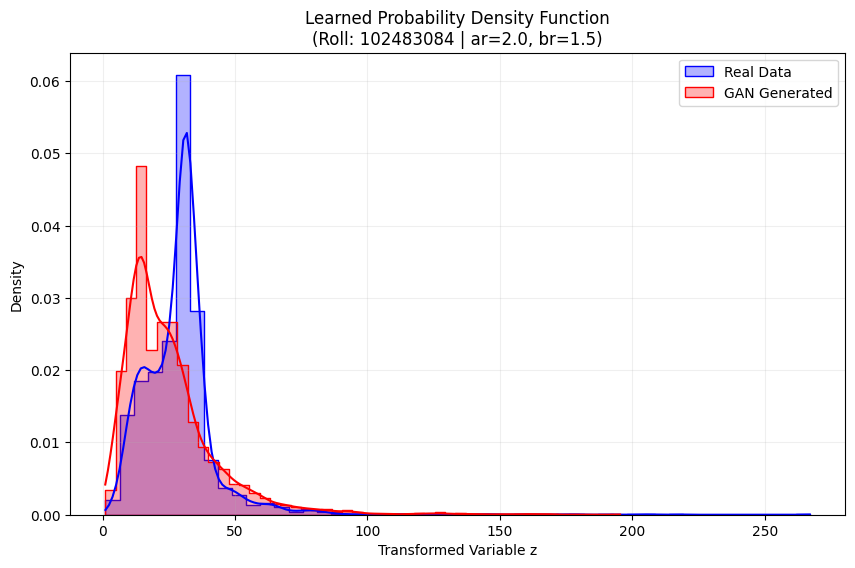

In [48]:
# Generate synthetic data for plotting
with torch.no_grad():
    large_noise = torch.randn(5000, 5)
    generated_scaled = generator(large_noise).numpy()

# Inverse transform to original scale
generated_data = scaler.inverse_transform(generated_scaled)
real_data_subset = z[:5000] # Compare with equal sample size

# Probability Density Function (Histogram + KDE)
plt.figure(figsize=(10, 6))
sns.histplot(real_data_subset.flatten(), bins=50, kde=True, stat="density", label='Real Data', color='blue', alpha=0.3, element="step")
sns.histplot(generated_data.flatten(), bins=50, kde=True, stat="density", label='GAN Generated', color='red', alpha=0.3, element="step")

plt.title(f'Learned Probability Density Function\n(Roll: {102483084} | ar={ar}, br={br})')
plt.xlabel('Transformed Variable z')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.2)

# Save plot for report
plt.savefig('gan_pdf_result.png') 
plt.show()